# 하이퍼파라미터 튜닝만

## 모듈 불러오기

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score
from collections import defaultdict

## 데이터 불러오기 및 시점별 데이터 추출

✅ 최적 RF 파라미터: {'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 100}
✅ 최적 XGB 파라미터: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}
✅ 최적 KNN 파라미터: {'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}

🎯 전체 모델 정확도: 0.7665


<Figure size 1000x800 with 0 Axes>

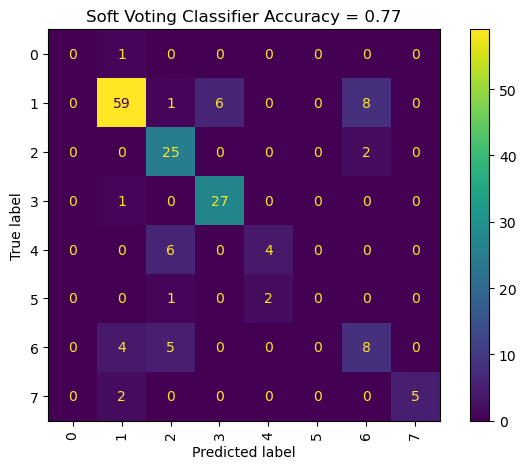


📌 클래스별 정확도 (CLUSTER_1 오름차순):
 - 0: 0.0000
 - 1: 0.7973
 - 2: 0.9259
 - 3: 0.9643
 - 4: 0.4000
 - 5: 0.0000
 - 6: 0.4706
 - 7: 0.7143

📊 분류 성능 보고서 (classification report):
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         1
           1     0.8806    0.7973    0.8369        74
           2     0.6579    0.9259    0.7692        27
           3     0.8182    0.9643    0.8852        28
           4     0.6667    0.4000    0.5000        10
           5     0.0000    0.0000    0.0000         3
           6     0.4444    0.4706    0.4571        17
           7     1.0000    0.7143    0.8333         7

    accuracy                         0.7665       167
   macro avg     0.5585    0.5340    0.5352       167
weighted avg     0.7608    0.7665    0.7550       167


🔁 [교차검증] 5-Fold 예측 수행 중...

✅ [교차검증] 전체 정확도: 0.7320
🌍 [교차검증] macro F1-score: 0.5882
⚖️ [교차검증] weighted F1-score: 0.7325

📊 [교차검증] classification report:
              precision

In [8]:
df = pd.read_csv('./datasets/must_use_final.csv')  
df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"])
df = df.sort_values("TIMESTAMP").reset_index(drop=True)
# 시점 정렬해서 5시간 시점만 추출하기 위해서

# ===== 시점 추출 =====
max_gap = pd.Timedelta(minutes=10) # 타겟 시점과 실제 데이터 시간의 최대 허용 오차를 10분으로 제한함
time_offsets = [3, 5, 9]  # 선박별로 출항 시점 기준으로 3,5,9 시간 뒤의 위치 데이터를 추출
time_based_data = {hour: [] for hour in time_offsets}  # 각 시간마다 추출된 데이터를 담을 빈 리스트로 시작함

for (vsl_id, port), group in df.groupby(["VSL_ID", "PORT_NAME"]): # 선박과 도착항구의 조합별로 데이터 나눠서 봄
    group = group.sort_values("TIMESTAMP")   # 해당 선박의 데이터를 시간순 정렬
    if group.empty:   # 비어있으면 contimue로 패스
        continue
    start_time = group["TIMESTAMP"].min()   # 출발 시점을 start time 설정
    for hour in time_offsets:
        target_time = start_time + pd.Timedelta(hours=hour)
        time_diff = (group["TIMESTAMP"] - target_time).abs()  # .abs() 절대값
        closest_idx = time_diff.idxmin()    # idxmin(): 가장 작은 차이를 가진 인덱스 추출
        if time_diff[closest_idx] <= max_gap: # max_gap 10 분 보다 시간 차이 크면 무시
            closest_row = group.loc[closest_idx]    # 조건 통과시 row 뽑아서 저장
            time_based_data[hour].append(closest_row) # time_based_data[hour] 여기에 추가
df_5h = pd.DataFrame(time_based_data[5]).reset_index(drop=True)  # 5시간 뒤 시의 데이터만 모음

# ===== 학습/테스트 분리 =====
feature_cols = ['LAT', 'LON', 'COG', 'HEADING']  # 독립 변수
target_col = 'CLUSTER_1'     # 종속변수
X = df_5h[feature_cols].values   # 값만 뽑아내기
y = df_5h[target_col].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)    # stratify=y : 클래스 비율 유지하면서 train/test 분할

# ===== RandomForest 하이퍼파라미터 튜닝 =====
param_grid_rf = {      # 여기서 정의한 값들을 조합해 최적 성능을 내는 조합을 찾는 과정
    'n_estimators': [100, 200],   # 트리 몇 개 만들지 (많을수록 성능 안정)
    'max_depth': [8, 10],       # 각 트리의 최대 깊이 (적절한 깊이가 중요)
    'min_samples_split': [2, 5],   # 노드 분할하기 위해 필요한 최소 샘플 수
    'max_features': ['sqrt', 'log2']   # 각 트리 노드를 분할할 때 몇 개 특성을 고려할지 / 'sqrt': 전체 특성 수의 제곱근 / 'log2': 전체 특성 수의 로그2
}

grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=42),
    param_grid=param_grid_rf,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
print("✅ 최적 RF 파라미터:", grid_rf.best_params_)

# ===== XGBoost 하이퍼파라미터 튜닝 =====
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}
grid_xgb = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    param_grid=param_grid_xgb,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)
grid_xgb.fit(X_train, y_train)
best_xgb = grid_xgb.best_estimator_
print("✅ 최적 XGB 파라미터:", grid_xgb.best_params_)

# ===== KNN 하이퍼파라미터 튜닝 =====
param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}
grid_knn = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid_knn,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)
grid_knn.fit(X_train, y_train)
best_knn = grid_knn.best_estimator_
print("✅ 최적 KNN 파라미터:", grid_knn.best_params_)

# ===== 최적 모델로 소프트 보팅 앙상블 구성 =====
classifier = VotingClassifier(estimators=[
    ('rf', best_rf),
    ('knn', best_knn),
    ('xgb', best_xgb)
], voting='soft')
classifier.fit(X_train, y_train)

# ===== 예측 및 정확도 출력 =====
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\n🎯 전체 모델 정확도: {accuracy:.4f}")

# ===== 혼동 행렬 시각화 =====
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
plt.figure(figsize=(10, 8))
disp.plot(xticks_rotation=90)
plt.title(f"Soft Voting Classifier Accuracy = {accuracy:.2f}")
plt.tight_layout()
plt.show()

# ===== 클래스별 정확도 계산 =====
class_accuracy = defaultdict(list)
for true_label, pred_label in zip(y_test, y_pred):
    class_accuracy[true_label].append(true_label == pred_label)

print("\n📌 클래스별 정확도 (CLUSTER_1 오름차순):")
for cls in sorted(class_accuracy.keys()):
    acc = np.mean(class_accuracy[cls])
    print(f" - {cls}: {acc:.4f}")

# ===== 정밀도, 재현율, F1-score 출력 =====
print("\n📊 분류 성능 보고서 (classification report):")
print(classification_report(y_test, y_pred, digits=4))

# ===== 교차검증 + macro F1-score 평가 =====
print("\n🔁 [교차검증] 5-Fold 예측 수행 중...")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred_cv = cross_val_predict(classifier, X, y, cv=skf)
acc_cv = accuracy_score(y, y_pred_cv)
macro_f1 = f1_score(y, y_pred_cv, average='macro')
weighted_f1 = f1_score(y, y_pred_cv, average='weighted')

print(f"\n✅ [교차검증] 전체 정확도: {acc_cv:.4f}")
print(f"🌍 [교차검증] macro F1-score: {macro_f1:.4f}")
print(f"⚖️ [교차검증] weighted F1-score: {weighted_f1:.4f}\n")

print("📊 [교차검증] classification report:")
print(classification_report(y, y_pred_cv, digits=4))

print("\n📌 [교차검증] CLUSTER_1별 정확도:")
class_accuracy_cv = defaultdict(list)
for true_label, pred_label in zip(y, y_pred_cv):
    class_accuracy_cv[true_label].append(true_label == pred_label)

for cls in sorted(class_accuracy_cv):
    acc = np.mean(class_accuracy_cv[cls])
    print(f" - CLUSTER_1 = {cls}: 정확도 {acc:.4f} ({len(class_accuracy_cv[cls])}개 샘플)")

# 복잡도 2로 줄이기

✅ 최적 RF 파라미터: {'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
✅ 최적 XGB 파라미터: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}
✅ 최적 KNN 파라미터: {'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}

🎯 전체 모델 정확도: 0.7605


<Figure size 1000x800 with 0 Axes>

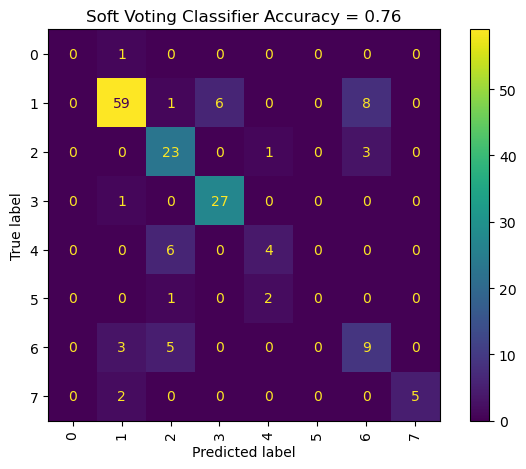


📌 클래스별 정확도 (CLUSTER_1 오름차순):
 - 0: 0.0000
 - 1: 0.7973
 - 2: 0.8519
 - 3: 0.9643
 - 4: 0.4000
 - 5: 0.0000
 - 6: 0.5294
 - 7: 0.7143

📊 분류 성능 보고서 (classification report):
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         1
           1     0.8939    0.7973    0.8429        74
           2     0.6389    0.8519    0.7302        27
           3     0.8182    0.9643    0.8852        28
           4     0.5714    0.4000    0.4706        10
           5     0.0000    0.0000    0.0000         3
           6     0.4500    0.5294    0.4865        17
           7     1.0000    0.7143    0.8333         7

    accuracy                         0.7605       167
   macro avg     0.5466    0.5321    0.5311       167
weighted avg     0.7585    0.7605    0.7526       167


🔁 [교차검증] 5-Fold 예측 수행 중...

✅ [교차검증] 전체 정확도: 0.7266
🌍 [교차검증] macro F1-score: 0.5832
⚖️ [교차검증] weighted F1-score: 0.7276

📊 [교차검증] classification report:
              precision

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score
from collections import defaultdict

# ===== 데이터 불러오기 =====
df = pd.read_csv('./datasets/must_use_final.csv')  # ← 파일 경로 확인
df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"])
df = df.sort_values("TIMESTAMP").reset_index(drop=True)

# ===== 시점 추출 =====
max_gap = pd.Timedelta(minutes=10)
time_offsets = [3, 5, 9]
time_based_data = {hour: [] for hour in time_offsets}

for (vsl_id, port), group in df.groupby(["VSL_ID", "PORT_NAME"]):
    group = group.sort_values("TIMESTAMP")
    if group.empty:
        continue
    start_time = group["TIMESTAMP"].min()
    for hour in time_offsets:
        target_time = start_time + pd.Timedelta(hours=hour)
        time_diff = (group["TIMESTAMP"] - target_time).abs()
        closest_idx = time_diff.idxmin()
        if time_diff[closest_idx] <= max_gap:
            closest_row = group.loc[closest_idx]
            time_based_data[hour].append(closest_row)

df_5h = pd.DataFrame(time_based_data[5]).reset_index(drop=True)

# ===== 학습/테스트 분리 =====
feature_cols = ['LAT', 'LON', 'COG', 'HEADING']
target_col = 'CLUSTER_1'
X = df_5h[feature_cols].values
y = df_5h[target_col].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# ===== RandomForest 하이퍼파라미터 튜닝 =====
param_grid_rf = {
    'n_estimators': [100],
    'max_depth': [3, 5, 8],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 5],
    'max_features': ['sqrt']
}

grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=42),
    param_grid=param_grid_rf,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
print("✅ 최적 RF 파라미터:", grid_rf.best_params_)

# ===== XGBoost 하이퍼파라미터 튜닝 =====
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}
grid_xgb = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    param_grid=param_grid_xgb,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)
grid_xgb.fit(X_train, y_train)
best_xgb = grid_xgb.best_estimator_
print("✅ 최적 XGB 파라미터:", grid_xgb.best_params_)

# ===== KNN 하이퍼파라미터 튜닝 =====
param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}
grid_knn = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid_knn,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)
grid_knn.fit(X_train, y_train)
best_knn = grid_knn.best_estimator_
print("✅ 최적 KNN 파라미터:", grid_knn.best_params_)

# ===== 최적 모델로 소프트 보팅 앙상블 구성 =====
classifier = VotingClassifier(estimators=[
    ('rf', best_rf),
    ('knn', best_knn),
    ('xgb', best_xgb)
], voting='soft')
classifier.fit(X_train, y_train)

# ===== 예측 및 정확도 출력 =====
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\n🎯 전체 모델 정확도: {accuracy:.4f}")

# ===== 혼동 행렬 시각화 =====
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
plt.figure(figsize=(10, 8))
disp.plot(xticks_rotation=90)
plt.title(f"Soft Voting Classifier Accuracy = {accuracy:.2f}")
plt.tight_layout()
plt.show()

# ===== 클래스별 정확도 계산 =====
class_accuracy = defaultdict(list)
for true_label, pred_label in zip(y_test, y_pred):
    class_accuracy[true_label].append(true_label == pred_label)

print("\n📌 클래스별 정확도 (CLUSTER_1 오름차순):")
for cls in sorted(class_accuracy.keys()):
    acc = np.mean(class_accuracy[cls])
    print(f" - {cls}: {acc:.4f}")

# ===== 정밀도, 재현율, F1-score 출력 =====
print("\n📊 분류 성능 보고서 (classification report):")
print(classification_report(y_test, y_pred, digits=4))

# ===== 교차검증 + macro F1-score 평가 =====
print("\n🔁 [교차검증] 5-Fold 예측 수행 중...")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred_cv = cross_val_predict(classifier, X, y, cv=skf)
acc_cv = accuracy_score(y, y_pred_cv)
macro_f1 = f1_score(y, y_pred_cv, average='macro')
weighted_f1 = f1_score(y, y_pred_cv, average='weighted')

print(f"\n✅ [교차검증] 전체 정확도: {acc_cv:.4f}")
print(f"🌍 [교차검증] macro F1-score: {macro_f1:.4f}")
print(f"⚖️ [교차검증] weighted F1-score: {weighted_f1:.4f}\n")

print("📊 [교차검증] classification report:")
print(classification_report(y, y_pred_cv, digits=4))

print("\n📌 [교차검증] CLUSTER_1별 정확도:")
class_accuracy_cv = defaultdict(list)
for true_label, pred_label in zip(y, y_pred_cv):
    class_accuracy_cv[true_label].append(true_label == pred_label)

for cls in sorted(class_accuracy_cv):
    acc = np.mean(class_accuracy_cv[cls])
    print(f" - CLUSTER_1 = {cls}: 정확도 {acc:.4f} ({len(class_accuracy_cv[cls])}개 샘플)")